# Comparing DMD and KDMD for Slow manifold dynamics

Here we consider perhaps one of the most widely known classic example of Koopman decomposition: a nonlinear system with a fast and slow manifold:

$$
\dot{x}_1 = \mu x_1 \\
\dot{x}_2 = \lambda (x_2-x_1^2)
$$
where $\mu=-0.05, \lambda=-1$. 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.cm as cm

import pykoopman as pk
from scipy.integrate import odeint
from scipy.stats.qmc import Sobol

Next we generate the data

(-0.9, 0.9)

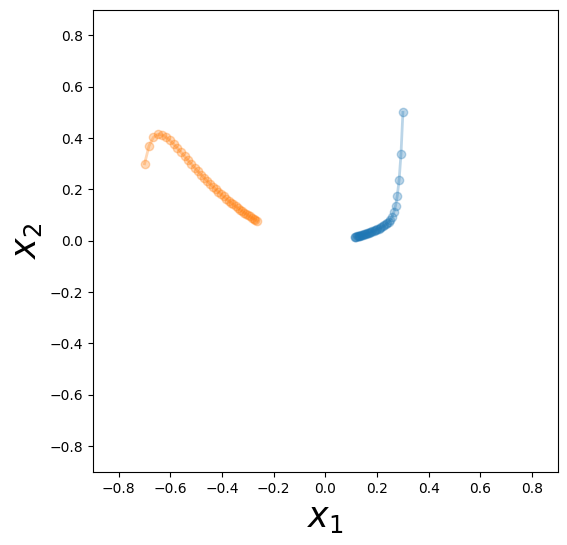

In [2]:
mu = -0.05
lda = -1.0
def slow_manifold(x, t, mu, lda):
    x1, x2 = x
    dxdt = [mu*x1, 
            lda*(x2-x1*x1)]
    return dxdt

n_t = 40
t = np.linspace(0, 20, n_t,endpoint=False)

# use quasi-random for generating samples
sampler=Sobol(d=2)


x_list = []
x_next_list = []
plt.figure(figsize=(6,6))
# for x0 in sampler.random(10)-0.5:
#     sol = odeint(slow_manifold, x0, t, args=(mu,lda))
#     plt.plot(sol[:,0],sol[:,1],'o-',lw=2,alpha=0.3)
    
#     x_list.append(sol[:-1])
#     x_next_list.append(sol[1:])

x0 = [0.3,0.5]
sol = odeint(slow_manifold, x0, t, args=(mu,lda))
plt.plot(sol[:,0],sol[:,1],'o-',lw=2,alpha=0.3)
x_list.append(sol[:-1])
x_next_list.append(sol[1:])

x0 = [-0.7,0.3]
sol = odeint(slow_manifold, x0, t, args=(mu,lda))
plt.plot(sol[:,0],sol[:,1],'o-',lw=2,alpha=0.3)
x_list.append(sol[:-1])
x_next_list.append(sol[1:])

plt.xlabel(r'$x_1$',size=25)
plt.ylabel(r'$x_2$',size=25)
plt.xlim([-0.9,0.9])
plt.ylim([-0.9,0.9])


Text(0, 0.5, '$x_2$')

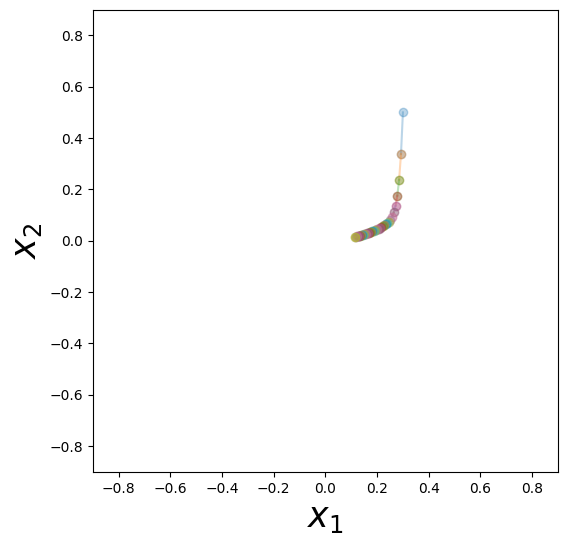

In [3]:
## single trajectory
data_st_X = np.vstack(x_list[:1])
data_st_Y = np.vstack(x_next_list[:1])


# plot
plt.figure(figsize=(6,6))
plt.plot([data_st_X[:,0],data_st_Y[:,0]],
         [data_st_X[:,1],data_st_Y[:,1]],'o-',alpha=0.3)    

plt.xlim([-0.9,0.9])
plt.ylim([-0.9,0.9])

plt.xlabel(r'$x_1$',size=25)
plt.ylabel(r'$x_2$',size=25)

Text(0, 0.5, '$x_2$')

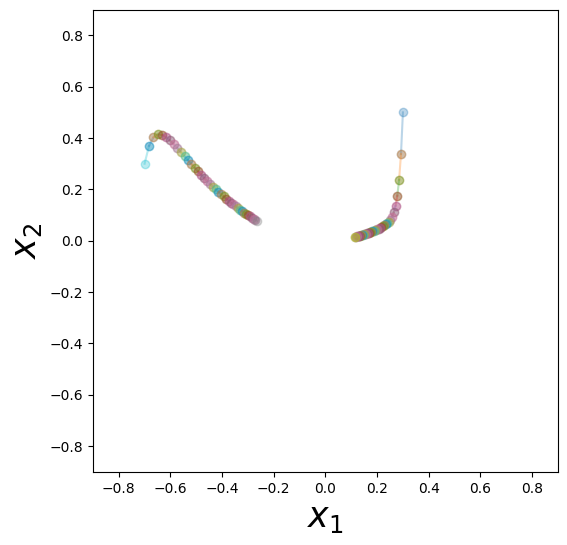

In [4]:
## two trajectories
data_2t_X = np.vstack(x_list[:2])
data_2t_Y = np.vstack(x_next_list[:2])

# plot
plt.figure(figsize=(6,6))
plt.plot([data_2t_X[:,0],data_2t_Y[:,0]],
         [data_2t_X[:,1],data_2t_Y[:,1]],'o-',alpha=0.3)    

plt.xlim([-0.9,0.9])
plt.ylim([-0.9,0.9])
plt.xlabel(r'$x_1$',size=25)
plt.ylabel(r'$x_2$',size=25)

## 1. Applying DMD

fitting 1 trajectory

continuous eigenvalue =  (-0.04999999821162009+0j)
continuous eigenvalue =  (-0.8793780367057831+0j)


(-0.9, 0.9)

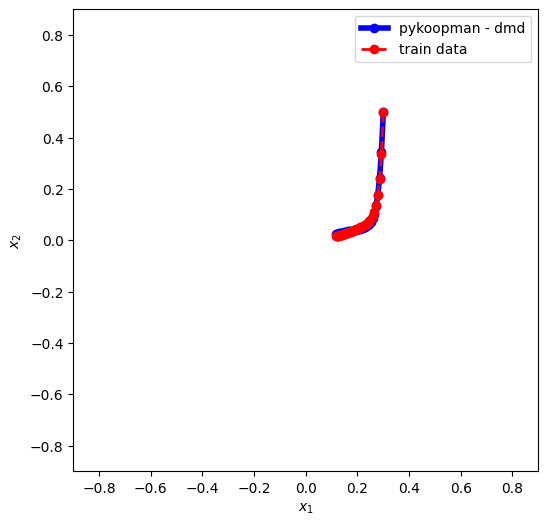

In [5]:
from pydmd import DMD
from pykoopman.regression import PyDMDRegressor 

regressor = DMD(svd_rank=2)
# regressor = PyDMDRegressor(DMD(svd_rank=2))

model_dmd = pk.Koopman(regressor=regressor)

# training
model_dmd.fit(data_st_X,data_st_Y)
model_dmd.time['dt']=t[1]-t[0]
for eigval in model_dmd.continuous_lamda_array:
    print('continuous eigenvalue = ',eigval)

# reconstruction
x0 = data_st_X[0:1]
x_tmp = x0
x_pred_list = [x_tmp]
for i in range(data_st_X.shape[0]-1):
    x_tmp = model_dmd.predict(x_tmp)
    x_pred_list.append(x_tmp)
    
X_pred = np.vstack(x_pred_list)

plt.figure(figsize=(6,6))
plt.plot(X_pred[:,0], X_pred[:,1],'-ob',lw=4,label='pykoopman - dmd')
plt.plot(data_st_X[:,0],data_st_X[:,1],'ro--',lw=2,label='train data')
plt.legend(loc='best')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.xlim([-0.9,0.9])
plt.ylim([-0.9,0.9])


fitting 2 trajectories

continuous eigenvalue =  (-0.0249999999747155+0j)
continuous eigenvalue =  (-0.14586482575904705+0j)


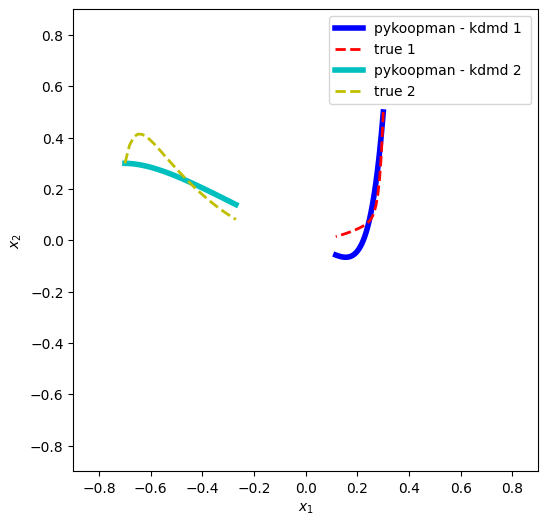

In [6]:
model_dmd.fit(data_2t_X,data_2t_Y)

x0 = data_2t_X[:1] 
x_tmp = x0
x_pred_list = [x_tmp]
for i in range(n_t-2):
    x_tmp = model_dmd.predict(x_tmp)
    x_pred_list.append(x_tmp)    
X_pred_1 = np.vstack(x_pred_list)

x0 = data_2t_X[n_t-1:n_t] 
x_tmp = x0
x_pred_list = [x_tmp]
for i in range(n_t-2):
    x_tmp = model_dmd.predict(x_tmp)
    x_pred_list.append(x_tmp)
    
X_pred_2 = np.vstack(x_pred_list)


plt.figure(figsize=(6,6))
plt.plot(X_pred_1[:,0], X_pred_1[:,1], '-b', lw=4, label='pykoopman - kdmd 1 ')
plt.plot(data_2t_X[:n_t-1,0], data_2t_X[:n_t-1,1], 'r--', lw=2, label='true 1 ')

plt.plot(X_pred_2[:,0], X_pred_2[:,1], '-c', lw=4, label='pykoopman - kdmd 2 ')
plt.plot(data_2t_X[n_t-1:,0], data_2t_X[n_t-1:,1], 'y--', lw=2, label='true 2')


plt.legend(loc='best')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.xlim([-0.9,0.9])
plt.ylim([-0.9,0.9])


# get eigenvalues
for eigval in model_dmd.continuous_lamda_array:
    print('continuous eigenvalue = ',eigval)

Conclusion: 1) vanilla DMD is not good for global linearization. 2) it cannot take more than 1 trajectory from highly nonlinear low-dimensional system (it will work for high-dimensional system where the number of harmonics is much less compared to system state)

## 2. Applying KDMD

First, let's find out what should be the right hyperparameter for kdmd

scale =  0.0001
scale =  0.0001603718743751331
scale =  0.00025719138090593444
scale =  0.0004124626382901352
scale =  0.0006614740641230146
scale =  0.0010608183551394483
scale =  0.0017012542798525892
scale =  0.0027283333764867696
scale =  0.004375479375074184
scale =  0.007017038286703823
scale =  0.011253355826007646
scale =  0.018047217668271703
scale =  0.028942661247167517
scale =  0.046415888336127774
scale =  0.07443803013251689
scale =  0.11937766417144358
scale =  0.19144819761699575
scale =  0.30702906297578497
scale =  0.49238826317067363
scale =  0.7896522868499725
scale =  1.2663801734674023
scale =  2.030917620904735
scale =  3.257020655659783
scale =  5.2233450742668435
scale =  8.376776400682925
scale =  13.433993325988988
scale =  21.54434690031882
scale =  34.55107294592218
scale =  55.41020330009492
scale =  88.86238162743408
scale =  142.51026703029964
scale =  228.54638641349885
scale =  366.5241237079626
scale =  587.8016072274912
scale =  942.6684551178854
sca

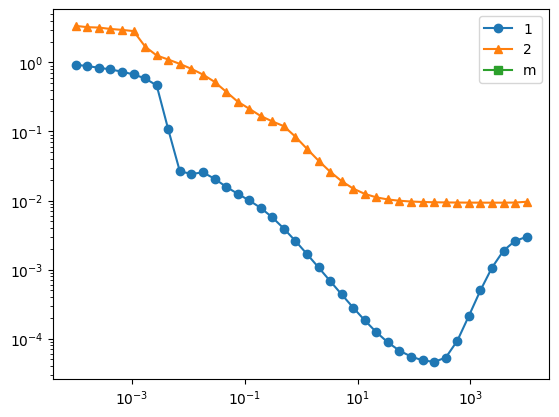

In [7]:
from pykoopman.regression import KDMD
from sklearn.gaussian_process.kernels import RBF, DotProduct, ConstantKernel

forward_backward=False
svd_rank = 5
tikhonov_regularization = 1e-12

err_st_list = []
err_2t_list = []
err_mt_list = []
scale_array = np.logspace(-4,4,40)
for scale in scale_array:
    regressor = KDMD(svd_rank=svd_rank, 
                     # kernel=DotProduct(sigma_0=scale),
                     kernel=RBF(length_scale=np.sqrt(scale)),
                     forward_backward=forward_backward,
                     tikhonov_regularization=tikhonov_regularization)

    model_kdmd = pk.Koopman(regressor=regressor)
    
    # single data
    model_kdmd.fit(data_st_X,data_st_Y)
    err_st = np.linalg.norm(model_kdmd.predict(data_st_X) - data_st_Y)
    
    # 2 trajectory data
    model_kdmd.fit(data_2t_X,data_2t_Y)
    err_2t = np.linalg.norm(model_kdmd.predict(data_2t_X) - data_2t_Y)
    
    # multiple data
    # model_kdmd.fit(data_mt_X_for_train,data_mt_Y_for_train)
    err_mt = 0 # np.linalg.norm(model_kdmd.predict(data_mt_X_for_train) - data_mt_Y_for_train)
    # model_kdmd.fit(data_mt_X_for_train,data_mt_Y_for_train)
    
    # model.fit(sol)
    # print(model.koopman_matrix.shape)

    err_st_list.append(err_st)
    err_2t_list.append(err_2t)
    err_mt_list.append(err_mt)
    
    print('scale = ',scale)
    
plt.loglog(scale_array, err_st_list,'-o',label='1')
plt.loglog(scale_array, err_2t_list,'-^',label='2')
plt.loglog(scale_array, err_mt_list,'-s',label='m')
plt.legend(loc='best')

choose the model with best hyperparameter, clearly here it is **overfitting** because we only have one trajectory

In [8]:
scale_st = scale_array[np.argmin(err_st_list)]
regressor_st = KDMD(svd_rank=svd_rank, 
                 kernel=RBF(length_scale=np.sqrt(scale_st)),
                 forward_backward=forward_backward,
                 tikhonov_regularization=tikhonov_regularization
                )

scale_2t = scale_array[np.argmin(err_2t_list)]
regressor_2t = KDMD(svd_rank=svd_rank, 
                 kernel=RBF(length_scale=np.sqrt(scale_2t)),
                 forward_backward=forward_backward,
                 tikhonov_regularization=tikhonov_regularization
                )

model_kdmd_st = pk.Koopman(regressor=regressor_st)
model_kdmd_2t = pk.Koopman(regressor=regressor_2t)

print('optimal scale 1 = ',scale_st)
print('optimal scale 2 = ',scale_2t)

optimal scale 1 =  228.54638641349885
optimal scale 2 =  2424.462017082326


1 trajectory

continuous eigenvalue =  (-0.9779338343830885+0j)
continuous eigenvalue =  (-0.4991054196688909+0j)
continuous eigenvalue =  (-1.1461145645411879e-07+0j)
continuous eigenvalue =  (-0.025013364252791843+0j)
continuous eigenvalue =  (-0.0507889574988651+0j)


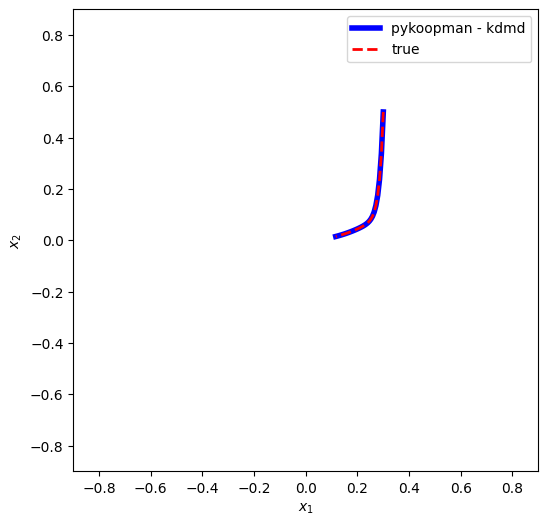

In [9]:
model_kdmd_st.fit(data_st_X,data_st_Y)

x0 = data_st_X[:1] 
x_tmp = x0
x_pred_list = [x_tmp]
for i in range(n_t-2):
    x_tmp = model_kdmd_st.predict(x_tmp)
    x_pred_list.append(x_tmp)
    
X_pred = np.vstack(x_pred_list)

plt.figure(figsize=(6,6))
plt.plot(X_pred[:,0], X_pred[:,1],'-b',lw=4,label='pykoopman - kdmd')
plt.plot(data_st_X[:,0],data_st_X[:,1],'r--',lw=2,label='true')
plt.legend(loc='best')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.xlim([-0.9,0.9])
plt.ylim([-0.9,0.9])

# get eigenvalues
for eigval in model_kdmd_st.continuous_lamda_array:
    print('continuous eigenvalue = ',eigval)

## Validate Koopman eigenfunction with an unseen trajectory

Text(0.5, 1.0, 'label is the continuous eigenvalue')

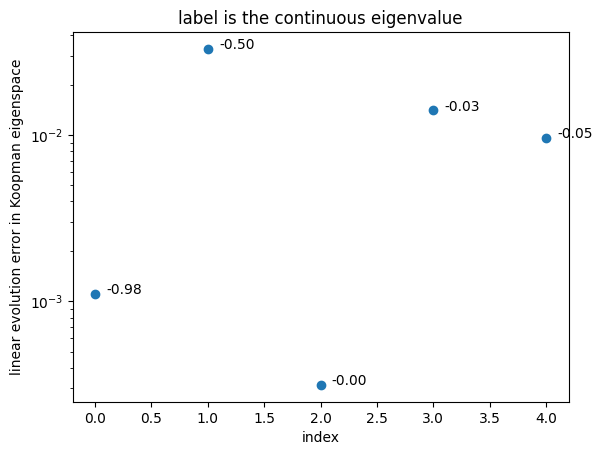

In [10]:
x0 = [0.2,-0.8]
sol_unseen = odeint(slow_manifold, x0, t, args=(mu,lda))

efun_index, linearity_error = model_kdmd_st.validity_check(t, sol_unseen)


plt.figure()
plt.scatter(efun_index,linearity_error )

for i in range(len(efun_index)):
    eigvals_c = np.log(np.diag(model_kdmd_st.lamda))/model_kdmd_st.time['dt']
    plt.text(1e-1+1.0*efun_index[i],linearity_error[i],
             "{:.2f}".format(eigvals_c[efun_index][i]))
plt.yscale('log')
plt.xlabel('index')
plt.ylabel('linear evolution error in Koopman eigenspace')
plt.title('label is the continuous eigenvalue')
# plt.plot(model_kdmd_2t.eigenvalues_continuous[efun_index])

Check out the validation error across 100 random unseen trajectories

Text(0, 0.5, 'linear evolution error')

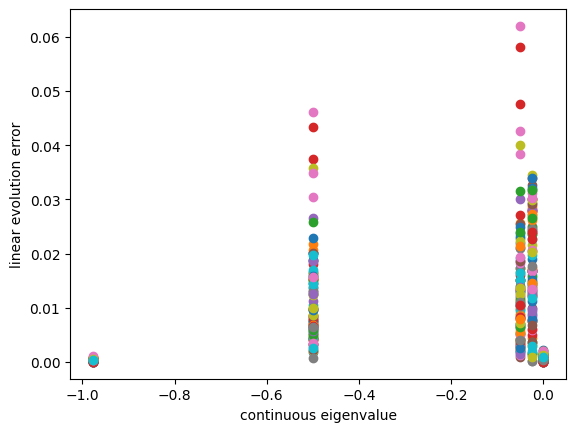

In [11]:
plt.figure()
x0_array = np.random.rand(100,2)-0.5
eigvals_c = np.log(np.diag(model_kdmd_st.lamda))/model_kdmd_st.time['dt']
for x0 in x0_array:
    sol_unseen = odeint(slow_manifold, x0, t, args=(mu,lda))
    efun_index, linearity_error = model_kdmd_st.validity_check(t, sol_unseen)
    
    plt.scatter(eigvals_c[efun_index],linearity_error)
    
plt.xlabel('continuous eigenvalue')
plt.ylabel('linear evolution error')

2 trajectories

continuous eigenvalue =  -1.0431235464865052
continuous eigenvalue =  -0.6536012509153168
continuous eigenvalue =  -1.8501500409531943e-06
continuous eigenvalue =  -0.05000267048514171
continuous eigenvalue =  -0.08628977920910907


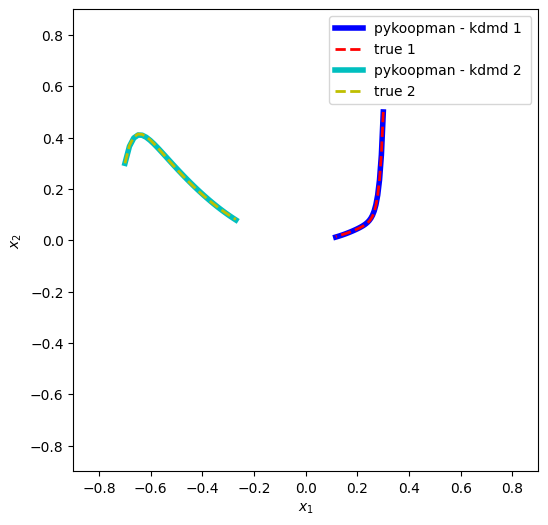

In [12]:
model_kdmd_2t.fit(data_2t_X,data_2t_Y)

x0 = data_2t_X[:1] 
x_tmp = x0
x_pred_list = [x_tmp]
for i in range(n_t-2):
    x_tmp = model_kdmd_2t.predict(x_tmp)
    x_pred_list.append(x_tmp)    
X_pred_1 = np.vstack(x_pred_list)

x0 = data_2t_X[n_t-1:n_t] 
x_tmp = x0
x_pred_list = [x_tmp]
for i in range(n_t-2):
    x_tmp = model_kdmd_2t.predict(x_tmp)
    x_pred_list.append(x_tmp)
    
X_pred_2 = np.vstack(x_pred_list)


plt.figure(figsize=(6,6))
plt.plot(X_pred_1[:,0], X_pred_1[:,1], '-b', lw=4, label='pykoopman - kdmd 1 ')
plt.plot(data_2t_X[:n_t-1,0], data_2t_X[:n_t-1,1], 'r--', lw=2, label='true 1 ')

plt.plot(X_pred_2[:,0], X_pred_2[:,1], '-c', lw=4, label='pykoopman - kdmd 2 ')
plt.plot(data_2t_X[n_t-1:,0], data_2t_X[n_t-1:,1], 'y--', lw=2, label='true 2')
plt.xlim([-0.9,0.9])
plt.ylim([-0.9,0.9])


plt.legend(loc='best')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

# get eigenvalues
model_kdmd_2t.time['dt']=t[1]-t[0]
for eigval in np.diag(model_kdmd_2t.lamda):
    print('continuous eigenvalue = ',np.log(eigval)/model_kdmd_2t.time['dt'])

## Validate the learned Koopman eigenfunction

Text(0.5, 1.0, 'label is the continuous eigenvalue')

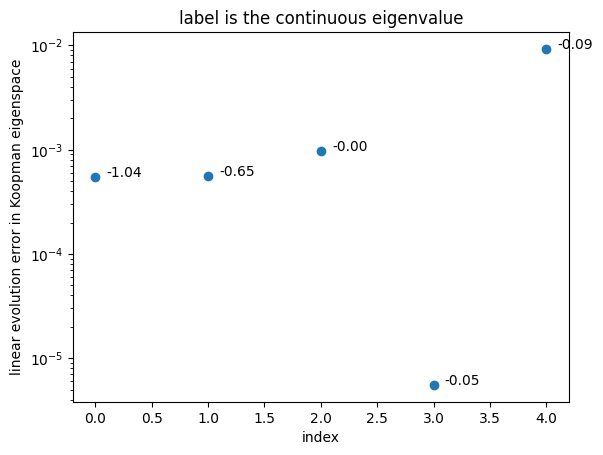

In [13]:
efun_index, linearity_error = model_kdmd_2t.validity_check(t, sol_unseen)

eigvals_c = np.log(np.diag(model_kdmd_2t.lamda))/model_kdmd_2t.time['dt']
plt.figure()
plt.scatter(efun_index,linearity_error )

for i in range(len(efun_index)):
    plt.text(1e-1+1.0*efun_index[i],linearity_error[i],
             "{:.2f}".format(eigvals_c[efun_index][i]))
plt.yscale('log')
plt.xlabel('index')
plt.ylabel('linear evolution error in Koopman eigenspace')
plt.title('label is the continuous eigenvalue')
# plt.plot(model_kdmd_2t.eigenvalues_continuous[efun_index])

Check out the validation error across 100 random unseen trajectories

Text(0, 0.5, 'linear evolution error')

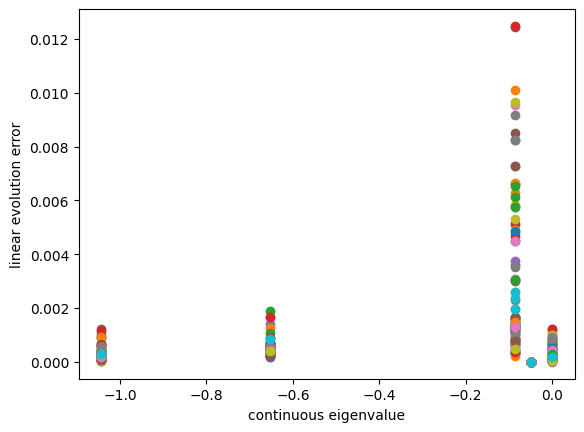

In [14]:
plt.figure()
x0_array = np.random.rand(100,2)-0.5
eigvals_c = np.log(np.diag(model_kdmd_2t.lamda))/model_kdmd_2t.time['dt']
for x0 in x0_array:
    sol_unseen = odeint(slow_manifold, x0, t, args=(mu,lda))
    efun_index, linearity_error = model_kdmd_2t.validity_check(t, sol_unseen)
    
    plt.scatter(eigvals_c[efun_index],linearity_error)
    
plt.xlabel('continuous eigenvalue')
plt.ylabel('linear evolution error')

Conclusion: 1) we can see -0.05 and -1 has very small validation error variance  2) it is likely that the one has largest variance is most likely to be the spurious mode

Access the matrices related to Koopman operator

In [15]:
model_kdmd_st.A.shape

(5, 5)

In [16]:
model_kdmd_st.C.shape

(2, 5)

In [17]:
model_kdmd_st.W.shape

(2, 5)